# Weaker Signal Simulation

## Goal

This notebook simulates the cases that the first trait is treated as focal trait, that have a weaker signals than the other traits. The first trait will be designed to have a less heritability (see details in Online Method in ColocBoost paper).

## Input

`genofile`: plink file of real genotyope, `plink_by_gene/extended_cis_before_winsorize_plink_files/*.bim`

The other parameters can be found in simxQTL repo. `https://github.com/StatFunGen/simxQTL`.

## Output

An `rds` object, with genotype matrix $X$ (dimension: $N \times P$ with $N$ samples, $P$ variants ) and phenotype (trait) matrix (dimension: $N \times L$ with $N$ samples and $L$ simulated traits).


Example output:

In [ ]:
result = readRDS("../simulation_data/simulation_GWAS/simulation_signal_0.02/causal_1/sample_1_h2g_0.02_GWAS_1.rds")
result$variant

[[1]]
[1] 824

[[2]]
[1] 824

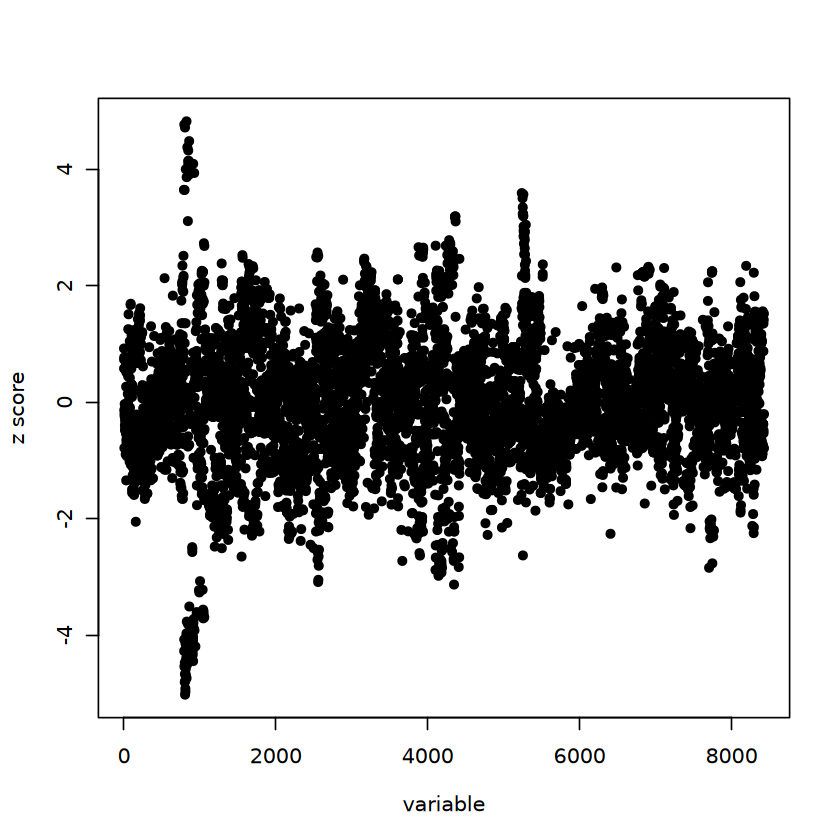

In [42]:
# Check their p values?
library(susieR)
par(family = "sans")
susie_res = susieR::susie(X = result$X, y = result$Y$Trait1, compute_univariate_zscore = TRUE)
susie_plot(susie_res, y = "z_original")

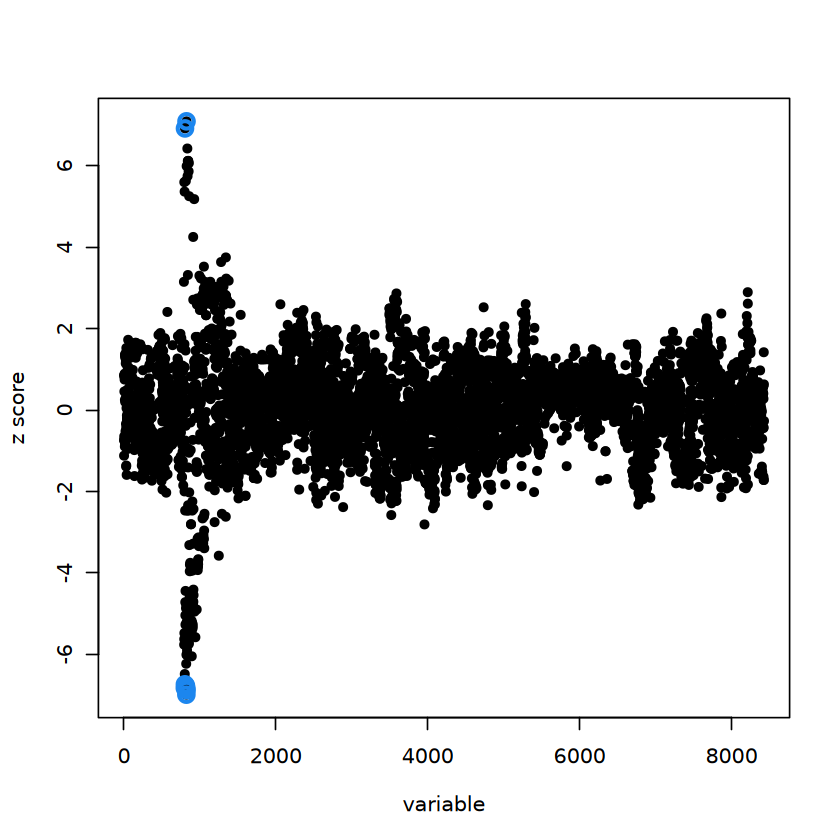

In [43]:
par(family = "sans")
susie_res = susieR::susie(X = result$X, y = result$Y$Trait2, compute_univariate_zscore = TRUE)
susie_plot(susie_res, y = "z_original")

In this case, the first trait (designed as GWAS) will not have fine-mapping CS result because of weak signal. 

In contrast, the second trait have a CS result.

## Phenotype simulation - 2 traits.

### Simulation code

In [ ]:
[GWAS_2trait]
# ======= Define parameters =======
parameter: genofile = paths
parameter: cwd = path("output")
parameter: job_size = 30
parameter: walltime = "100h"
parameter: mem = "30G"
parameter: numThreads = 1
parameter: n_trait = 2
parameter: h2g = 0.02  # weaker heritability for Trait 1
parameter: ncausal = 1
parameter: total_h2g = False
parameter: share_pattern = "all"
parameter: independent = False
parameter: container = ""

# ======= Workflow input/output =======
input: genofile, group_by = 1
output: f'{cwd:a}/{step_name}/sample_{_index}_2_trait_simulation.rds'

task: trunk_workers = 1, trunk_size = job_size, walltime = walltime, mem = mem, cores = numThreads, tags = f'{step_name}_{_output[0]:bn}'

# ======= Main R block =======
R: expand = '${ }', stdout = f"{_output:n}.stdout", stderr = f"{_output:n}.stderr", container = container

    # --- Load necessary libraries ---
    library("MASS")
    library("plink2R")
    library("dplyr")
    library("readr")
    library("tidyverse")
  
    # install simulation package
    # devtools::install_github("StatFunGen/simxQTL", build_vignettes = FALSE)
    # BiocManager::install("StatFunGen/pecotmr")
    library("pecotmr")
    library("simxQTL")

    # --- Read genotype data ---
    simu_file = ${_input:r}
    geno <- read_plink(${_input:nr})

    # --- Extract gene name and TSS ---
    gene_name = str_extract(simu_file, "ENSG[0-9]+")
    gene_tss_map = read_tsv("./Data/gene_cis_TADB_mapper.tsv")
    TSS_pos = gene_tss_map$TSS[which(gene_tss_map$gene_id == gene_name)][1]

    # --- Filter SNPs by distance to TSS ---
    keep_index = which(geno$bim$V4 > TSS_pos - 1500000 | geno$bim$V4 < TSS_pos + 1500000)
    geno$bed = geno$bed[, keep_index]

    # --- Apply SNP filters: missingness and MAF ---
    imiss = 0.1
    maf = 0.05
    Xmat = filter_X(geno$bed, imiss, maf)

    # ======= Select causal variants manually =======
    indep = ${"TRUE" if independent else "FALSE"}

    if (indep) {
        LD_vars = 1  # Initialize LD check

        if (ncausal == 1) {
            # Only one causal variant needed
            vars = sample(1:ncol(Xmat), size = ncausal)
        } else {
            # Ensure selected variants are approximately independent (LD < 0.3)
            while (length(LD_vars != 0)) {
                vars = sample(1:ncol(Xmat), size = ncausal)
                cor_mat = cor(Xmat[, vars])
                LD_vars = which(colSums(abs(cor_mat) > 0.3) > 1)
            }
        }
    } else {
        LD_vars = 1  # Initialize LD check

        if (ncausal == 1) {
            vars = sample(1:ncol(Xmat), size = ncausal)
        } else {
            # Avoid perfectly correlated variants (|cor| = 1)
            while (length(LD_vars != 0)) {
                vars = sample(1:ncol(Xmat), size = ncausal)
                cor_mat = cor(Xmat[, vars])
                LD_vars = which(colSums(abs(cor_mat) == 1) > 1)
            }
        }
    }

    # ======= Assign effects manually =======
    ntrait = ${n_trait}
    B = matrix(0, nrow = ncol(Xmat), ncol = ntrait)

    phenotype = list()

    # First trait: weaker heritability (h2g specified by parameter)
    i = 1
    beta = sim_beta_fix_variant(G = Xmat, causal_index = vars, is_h2g_total = FALSE)
    B[, i] = beta
    pheno_single = sim_multi_traits(
        G = Xmat,
        B = B[, i, drop = FALSE],
        h2g = ${h2g},  # weaker h2g
        is_h2g_total = FALSE
    )
    phenotype[[i]] = pheno_single$P

    # Second trait: normal heritability (hardcoded here 0.05)
    i = 2
    beta = sim_beta_fix_variant(G = Xmat, causal_index = vars, is_h2g_total = FALSE)
    B[, i] = beta
    pheno_single = sim_multi_traits(
        G = Xmat,
        B = B[, i, drop = FALSE],
        h2g = 0.05,   # normal h2g
        is_h2g_total = FALSE
    )
    phenotype[[i]] = pheno_single$P

    # ======= Assemble final dataset =======
    variant = list()
    for (i in 1:ncol(B)) {
        variant[[i]] = which(B[, i] != 0)
    }

    X = Xmat
    Y = bind_cols(phenotype)
    colnames(Y) = paste0("Trait", 1:ntrait)

    data = list()
    data[["X"]] = X
    data[["Y"]] = Y
    data[["variant"]] = variant

    # ======= Save final dataset =======
    saveRDS(data, ${_output:r})


## Simulation GWAS - 5 traits

In [ ]:
[GWAS_5trait]
# ======= Define parameters =======
parameter: genofile = paths
parameter: cwd = path("output")
parameter: job_size = 30
parameter: walltime = "100h"
parameter: mem = "30G"
parameter: numThreads = 1
parameter: n_trait = 5
parameter: n_causal = 1
parameter: h2g = 0.02  # weaker h2g for the first trait
parameter: total_h2g = False
parameter: share_pattern = "all"
parameter: independent = False
parameter: container = ""

# ======= Workflow input/output =======
input: genofile, group_by = 1
output: f'{cwd:a}/{step_name}/sample_{_index}_5trait_simulation.rds'

task: trunk_workers = 1, trunk_size = job_size, walltime = walltime, mem = mem, cores = numThreads, tags = f'{step_name}_{_output[0]:bn}'

# ======= Main R block =======
R: expand = '${ }', stdout = f"{_output:n}.stdout", stderr = f"{_output:n}.stderr", container = container

    # --- Load necessary libraries ---
    library("MASS")
    library("plink2R")
    library("dplyr")
    library("readr")
    library("tidyverse")
  
    # install simulation package
    # devtools::install_github("StatFunGen/simxQTL", build_vignettes = FALSE)
    # BiocManager::install("StatFunGen/pecotmr")
    library("pecotmr")
    library("simxQTL")

    # --- Read genotype data ---
    simu_file = ${_input:r}
    geno <- read_plink(${_input:nr})

    # --- Extract gene name and TSS ---
    gene_name = str_extract(simu_file, "ENSG[0-9]+")
    gene_tss_map = read_tsv("./Data/gene_cis_TADB_mapper.tsv")
    TSS_pos = gene_tss_map$TSS[which(gene_tss_map$gene_id == gene_name)][1]

    # --- Filter SNPs by distance to TSS ---
    keep_index = which(geno$bim$V4 > TSS_pos - 1500000 | geno$bim$V4 < TSS_pos + 1500000)
    geno$bed = geno$bed[, keep_index]

    # --- Apply SNP filters: missingness and MAF ---
    imiss = 0.1
    maf = 0.05
    Xmat = filter_X(geno$bed, imiss, maf)

    # ======= Select causal variants manually =======
    ncausal = ${n_causal}
    ntrait = ${n_trait}
    indep = ${"TRUE" if independent else "FALSE"}

    if (indep) {
        LD_vars = 1  # Initialize LD check

        if (ncausal == 1) {
            # Only one causal variant needed
            vars = sample(1:ncol(Xmat), size = ncausal)
        } else {
            # Ensure selected variants are approximately independent (LD < 0.3)
            while (length(LD_vars != 0)) {
                vars = sample(1:ncol(Xmat), size = ncausal)
                cor_mat = cor(Xmat[, vars])
                LD_vars = which(colSums(abs(cor_mat) > 0.3) > 1)
            }
        }
    } else {
        LD_vars = 1  # Initialize LD check

        if (ncausal == 1) {
            vars = sample(1:ncol(Xmat), size = ncausal)
        } else {
            # Avoid perfectly correlated variants (|cor| = 1)
            while (length(LD_vars != 0)) {
                vars = sample(1:ncol(Xmat), size = ncausal)
                cor_mat = cor(Xmat[, vars])
                LD_vars = which(colSums(abs(cor_mat) == 1) > 1)
            }
        }
    }

    # ======= Load predefined proportions for trait sharing =======
    prop <- readRDS("./Data/trait6_prop.rds")[, 1:4]
    proportions <- prop[ncausal, ]
    sampled_name <- as.numeric(sample(names(proportions), size = ncausal, prob = proportions, replace = TRUE))

    # ======= Assign effects manually =======
    B = matrix(0, nrow = ncol(Xmat), ncol = ntrait)
    config = matrix(0, nrow = ntrait, ncol = ncausal)

    for (i in 1:ncausal) {
        coloc_trait <- sample(1:ntrait, sampled_name[i])
        config[coloc_trait, i] <- 1
    }

    phenotype = list()

    for (i in 1:nrow(config)) {
        beta = B[, i, drop = FALSE]
        index = which(config[i, ] == 1)

        # First trait (Trait 1) has lower heritability
        if (i == 1) {
            h2g_trait = ${h2g}
        } else {
            h2g_trait = 0.05
        }

        if (length(index) > 0) {
            causal_index = vars[index]
            beta = sim_beta_fix_variant(G = Xmat, causal_index = causal_index, is_h2g_total = FALSE)
            B[, i] = beta
            pheno_single = sim_multi_traits(G = Xmat, B = as.matrix(beta), h2g = h2g_trait, is_h2g_total = FALSE)
            phenotype[[i]] = pheno_single$P
        } else {
            pheno_single = sim_multi_traits(G = Xmat, B = as.matrix(beta), h2g = h2g_trait, is_h2g_total = FALSE)
            phenotype[[i]] = pheno_single$P
        }
    }

    # ======= Assemble final dataset =======
    variant = list()
    for (i in 1:ncol(B)) {
        variant[[i]] = which(B[, i] != 0)
    }

    X = Xmat
    Y = bind_cols(phenotype)
    colnames(Y) = paste0("Trait", 1:ntrait)

    data = list()
    data[["X"]] = X
    data[["Y"]] = Y
    data[["variant"]] = variant

    # ======= Save final dataset =======
    saveRDS(data, ${_output:r})


## Simulation GWAS - 10 traits

In [ ]:
[GWAS_10trait]
# ======= Define parameters =======
parameter: genofile = paths
parameter: cwd = path("output")
parameter: job_size = 30
parameter: walltime = "100h"
parameter: mem = "30G"
parameter: numThreads = 1
parameter: n_trait = 10
parameter: n_causal = 1
parameter: h2g = 0.02  # weaker h2g for first trait (GWAS)
parameter: total_h2g = False
parameter: share_pattern = "all"
parameter: independent = False
parameter: container = ""

# ======= Workflow input/output =======
input: genofile, group_by = 1
output: f'{cwd:a}/{step_name}/sample_{_index}_10trait_simulation.rds'

task: trunk_workers = 1, trunk_size = job_size, walltime = walltime, mem = mem, cores = numThreads, tags = f'{step_name}_{_output[0]:bn}'

# ======= Main R block =======
R: expand = '${ }', stdout = f"{_output:n}.stdout", stderr = f"{_output:n}.stderr", container = container

    # --- Load necessary libraries ---
    library("MASS")
    library("plink2R")
    library("dplyr")
    library("readr")
    library("tidyverse")
  
    # install simulation package
    # devtools::install_github("StatFunGen/simxQTL", build_vignettes = FALSE)
    # BiocManager::install("StatFunGen/pecotmr")
    library("pecotmr")
    library("simxQTL")

    # --- Read genotype data ---
    simu_file = ${_input:r}
    geno <- read_plink(${_input:nr})

    # --- Extract gene name and TSS ---
    gene_name = str_extract(simu_file, "ENSG[0-9]+")
    gene_tss_map = read_tsv("/home/hs3393/coloc/fungen-xqtl-analysis/resource/gene_cis_TADB_mapper.tsv")
    TSS_pos = gene_tss_map$TSS[which(gene_tss_map$gene_id == gene_name)][1]

    # --- Filter SNPs by distance to TSS ---
    keep_index = which(geno$bim$V4 > TSS_pos - 1500000 | geno$bim$V4 < TSS_pos + 1500000)
    geno$bed = geno$bed[, keep_index]

    # --- Apply SNP filters: missingness and MAF ---
    imiss = 0.1
    maf = 0.05
    Xmat = filter_X(geno$bed, imiss, maf)

    # ======= Select causal variants manually =======
    ncausal = ${n_causal}
    ntrait = ${n_trait}
    indep = ${"TRUE" if independent else "FALSE"}

    if (indep) {
        LD_vars = 1  # Initialize LD check

        if (ncausal == 1) {
            # Only one causal variant needed
            vars = sample(1:ncol(Xmat), size = ncausal)
        } else {
            # Ensure selected variants are approximately independent (LD < 0.3)
            while (length(LD_vars != 0)) {
                vars = sample(1:ncol(Xmat), size = ncausal)
                cor_mat = cor(Xmat[, vars])
                LD_vars = which(colSums(abs(cor_mat) > 0.3) > 1)
            }
        }
    } else {
        LD_vars = 1  # Initialize LD check

        if (ncausal == 1) {
            vars = sample(1:ncol(Xmat), size = ncausal)
        } else {
            # Avoid perfectly correlated variants (|cor| = 1)
            while (length(LD_vars != 0)) {
                vars = sample(1:ncol(Xmat), size = ncausal)
                cor_mat = cor(Xmat[, vars])
                LD_vars = which(colSums(abs(cor_mat) == 1) > 1)
            }
        }
    }

    # ======= Load predefined proportions for trait sharing =======
    prop <- readRDS("./Data/trait10_prop.rds")
    proportions <- prop[ncausal, ]
    sampled_name <- as.numeric(sample(names(proportions), size = ncausal, prob = proportions, replace = TRUE))

    # ======= Assign effects manually =======
    B = matrix(0, nrow = ncol(Xmat), ncol = ntrait)
    config = matrix(0, nrow = ntrait, ncol = ncausal)

    for (i in 1:ncausal) {
        coloc_trait <- sample(1:ntrait, sampled_name[i])
        config[coloc_trait, i] <- 1
    }

    phenotype = list()

    for (i in 1:nrow(config)) {
        beta = B[, i, drop = FALSE]
        index = which(config[i, ] == 1)

        # First trait (Trait 1) has lower heritability
        if (i == 1) {
            h2g_trait = ${h2g}
        } else {
            h2g_trait = 0.05
        }

        if (length(index) > 0) {
            causal_index = vars[index]
            beta = sim_beta_fix_variant(G = Xmat, causal_index = causal_index, is_h2g_total = FALSE)
            B[, i] = beta
            pheno_single = sim_multi_traits(G = Xmat, B = as.matrix(beta), h2g = h2g_trait, is_h2g_total = FALSE)
            phenotype[[i]] = pheno_single$P
        } else {
            pheno_single = sim_multi_traits(G = Xmat, B = as.matrix(beta), h2g = h2g_trait, is_h2g_total = FALSE)
            phenotype[[i]] = pheno_single$P
        }
    }

    # ======= Assemble final dataset =======
    variant = list()
    for (i in 1:ncol(B)) {
        variant[[i]] = which(B[, i] != 0)
    }

    X = Xmat
    Y = bind_cols(phenotype)
    colnames(Y) = paste0("Trait", 1:ntrait)

    data = list()
    data[["X"]] = X
    data[["Y"]] = Y
    data[["variant"]] = variant

    # ======= Save final dataset =======
    saveRDS(data, ${_output:r})


### Bash submission

In [ ]:
work_dir="/home/hs3393/cb_Mar/simulation_data/simulation_GWAS/"
job="simulation_GWAS"
mkdir -p ${work_dir}
mkdir -p ${work_dir}/code
mkdir -p ${work_dir}/log
cd ${work_dir}/code

# Create the base_script file and write the bash code into it
cat << 'EOF' > base_script
#!/bin/bash -l
# NOTE the -l flag!
#
#SBATCH -t 30:00:00
#SBATCH --mem=30000
#SBATCH -J GWAS_simu
#SBATCH -o WORK_DIR/log/JOB."%j".out
#SBATCH -e WORK_DIR/log/JOB."%j".err

source ~/mamba_activate.sh
module load Singularity


sos run ./6_GWAS_Simulation.ipynb JOB \
    --genofile `ls /home/hs3393/cloud_colocalization/simulation_data/selected_genes_genotype/*.bim` \
    --mem 30G --h2g H2G --ncausal VAR --n_trait 2 --independent \
    --cwd WORK_DIR/simulation_signal_H2G/causal_VAR
EOF

base_script="base_script"
for variant in 1 2 3; do
    for h2g in 0.02 0.03 0.04 0.05; do
        output_script="variant_${variant}_h2g_${h2g}.sh"
        cat ${base_script}|sed "s|H2G|${h2g}|g" | sed "s|VAR|${variant}|g" | sed "s|WORK_DIR|${work_dir}|g" |sed "s|JOB|${job}|g"  > ${output_script}
        sbatch ${output_script}
    done
done

In [ ]:
work_dir="/home/hs3393/cb_Mar/simulation_data/simulation_GWAS/GWAS_5trait/"
job="GWAS_5trait"
mkdir -p ${work_dir}
mkdir -p ${work_dir}/code
mkdir -p ${work_dir}/log
cd ${work_dir}/code

# Create the base_script file and write the bash code into it
cat << 'EOF' > base_script
#!/bin/bash -l
# NOTE the -l flag!
#
#SBATCH -t 30:00:00
#SBATCH --mem=30000
#SBATCH -J GWAS_simu
#SBATCH -o WORK_DIR/log/JOB."%j".out
#SBATCH -e WORK_DIR/log/JOB."%j".err

source ~/mamba_activate.sh
module load Singularity


sos run ./6_GWAS_Simulation.ipynb JOB \
    --genofile `ls /home/hs3393/cloud_colocalization/simulation_data/selected_genes_genotype/*.bim` \
    --mem 30G --h2g H2G --ncausal VAR --n_trait 5 --independent \
    --cwd WORK_DIR/simulation_signal_H2G/causal_VAR
EOF

base_script="base_script"
for variant in 1 2 3; do
    for h2g in 0.02 0.03 0.04 0.05; do
        output_script="variant_${variant}_h2g_${h2g}.sh"
        cat ${base_script}|sed "s|H2G|${h2g}|g" | sed "s|VAR|${variant}|g" | sed "s|WORK_DIR|${work_dir}|g" |sed "s|JOB|${job}|g"  > ${output_script}
        sbatch ${output_script}
    done
done

In [ ]:
work_dir="/home/hs3393/cb_Mar/simulation_data/simulation_GWAS/GWAS_10trait/"
job="GWAS_10trait"
mkdir -p ${work_dir}
mkdir -p ${work_dir}/code
mkdir -p ${work_dir}/log
cd ${work_dir}/code

# Create the base_script file and write the bash code into it
cat << 'EOF' > base_script
#!/bin/bash -l
# NOTE the -l flag!
#
#SBATCH -t 30:00:00
#SBATCH --mem=30000
#SBATCH -J GWAS_simu
#SBATCH -o WORK_DIR/log/JOB."%j".out
#SBATCH -e WORK_DIR/log/JOB."%j".err

source ~/mamba_activate.sh
module load Singularity


sos run ./6_GWAS_Simulation.ipynb JOB \
    --genofile `ls /home/hs3393/cloud_colocalization/simulation_data/selected_genes_genotype/*.bim` \
    --mem 30G --h2g H2G --ncausal VAR --n_trait 10 --independent \
    --cwd WORK_DIR/simulation_signal_H2G/causal_VAR
EOF

base_script="base_script"
for variant in 1 2 3; do
    for h2g in 0.02 0.03 0.04 0.05; do
        output_script="variant_${variant}_h2g_${h2g}.sh"
        cat ${base_script}|sed "s|H2G|${h2g}|g" | sed "s|VAR|${variant}|g" | sed "s|WORK_DIR|${work_dir}|g" |sed "s|JOB|${job}|g"  > ${output_script}
        sbatch ${output_script}
    done
done

### Bash job submission

In [ ]:
data_dir="/home/hs3393/cb_Mar/simulation_data/simulation_GWAS/"
job="colocboost_target"
work_dir="/home/hs3393/cb_Mar/simulation_result/simulation_GWAS/"
#!/bin/bash

mkdir -p ${work_dir}/${job}/code
mkdir -p ${work_dir}/${job}/log
mkdir -p ${work_dir}/${job}/result

cd ${work_dir}/${job}/code

cat << 'EOF' > base_script
#!/bin/bash -l
# NOTE the -l flag!
#
#SBATCH -t 100:00:00
#SBATCH --mem=30000
#SBATCH -J JOB
#SBATCH -o WORK_DIR/JOB/log/JOB.%j.out
#SBATCH -e WORK_DIR/JOB/log/JOB.%j.err

source /home/hs3393/mamba_activate.sh
module load Singularity

cd DATA_DIR/simulation_signal_H2G/causal_VAR

sos run /home/hs3393/cb_Mar/simulation_code/2_Run_Colocboost.ipynb JOB \
    --simufile $(find -type f -name '*.rds') \
    --mem 30G --trait 2 \
    --cwd WORK_DIR/JOB/simulation_signal_H2G/causal_VAR
EOF


base_script="base_script"
for variant in 1 2 3; do
    for h2g in 0.02 0.03 0.04 0.05; do
        output_script="variant_${variant}_h2g_${h2g}.sh"
        cat ${base_script}|sed "s|H2G|${h2g}|g" | sed "s|VAR|${variant}|g" | sed "s|WORK_DIR|${work_dir}|g"  | sed "s|DATA_DIR|${data_dir}|g" |sed "s|JOB|${job}|g"  > ${output_script}
        sbatch ${output_script}
    done
done

### Result summary

In [ ]:
data_dir="/home/hs3393/cb_Mar/simulation_result/simulation_GWAS/colocboost_target/"
mkdir -p ${data_dir}/summary
cd ${data_dir}/summary

cat << 'EOF' > summary_script
#!/bin/bash -l
# NOTE the -l flag!
#
#SBATCH -t 8:00:00
#SBATCH --mem=30000
#SBATCH -J sum
#SBATCH -o DATA_DIR/log/summary."%j".out
#SBATCH -e DATA_DIR/log/summary."%j".err

source ~/mamba_activate.sh

sos run /home/hs3393/cb_Mar/simulation_code/4.Result_Summary.ipynb coloc_target_summary \
    --folder DATA_DIR/ \
    --cwd DATA_DIR/summary
EOF


base_script="summary_script"
output_script="summary.sh"
cat ${base_script}|  sed "s|DATA_DIR|${data_dir}|g"  > ${output_script}
sbatch ${output_script}